# Actividad 1

## Requisitos

- Habitación de MxN espacios.
- Número de agentes.
- Porcentaje de celdas inicialmente sucias.
- Tiempo máximo de ejecución.

## Instrucciones

- Inicializa las celdas sucias (ubicaciones aleatorias).
- Todos los agentes empiezan en posiciones aleatorias.
- En cada paso de tiempo:
    - Si la celda está sucia, entonces aspira.
    - Si la celda está limpia, 
        - El agente elije mover a una nueva celda, usando esta selección: norte, este, sur, oeste.
        - El agente se moverá a esa celda siempre y cuando no la haya visitado antes. 
        - Si no tiene opciones para moverse, el agente se moverá a la celda que previamente haya visitado.
        - Si ya no tiene más opciones, el agente se detiene.
- Se ejecuta el tiempo máximo establecido.

Empleando siempre la misma cantidad de agentes (más de 2), determina:

- ¿Cuál es el tiempo necesario hasta que todas las celdas estén limpias?
- Empleando un número máximo de iteraciones, ¿cuál es el porcentaje de celdas limpias después del termino de la simulación?
- En ambos casos, ¿cuál es la cantidad de movimientos realizados por los agentes?

Desarrolla un documento analizando los resultados obtenidos.

## Evaluación 

45% - El código cumple correctamente con la funcionalidad requerida por parte de la actividad.
10% - El código deberá seguir los lineamientos estipulados en el estándar de codificación: liga_estándar_codificación
Download liga_estándar_codificación.
45% - El informe presenta un análisis del problema planteado, así como las conclusiones obtenidas del mismo.

In [300]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Necesitamos agentes por celdas, usamos MultiGrid
from mesa.space import MultiGrid

# Con ''RandomActivation, hacemos que todos los agentes se activen ''al azar''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime



In [301]:
class VaccumCleaner(Agent):
    # initialize class, define id and space occupied (model)
    def __init__(self, id, model):
        super().__init__(id, model)
        self.model = model
        self.visited_places = [self.pos]
    
    # def move(self):
    #     x_pos, y_pos = self.pos
    #     north = (x_pos, y_pos + 1)
    #     south = (x_pos, y_pos - 1)
    #     east = (x_pos + 1, y_pos)
    #     west = (x_pos - 1, y_pos)
        
    #     # North
    #     if not self.model.grid.out_of_bounds(north):
    #         self.model.grid.move_agent(self, north)
    #     # East
    #     elif not self.model.grid.out_of_bounds(east): 
    #         self.model.grid.move_agent(self, east)
    #     # South
    #     elif not self.model.grid.out_of_bounds(south): 
    #         self.model.grid.move_agent(self, south)
    #     # West
    #     elif not self.model.grid.out_of_bounds(west): 
    #         self.model.grid.move_agent(self, west)
    #     else:
    #         self.model.grid.move_agent(self, (x_pos, y_pos) )

    def out_of_bounds(self, pos):
        pos_x, pos_y = pos
        width, height = self.model.cells.shape
        # if out_of_bounds, return true
        if (pos_x > width or pos_x < 0) or (pos_y > height or pos_y < 0):
            return True
        else:
            return False

    def move(self):
        # get possible movement 
        movement = self.model.grid.get_neighborhood(self.pos, moore=False)

        # invert y axis
        movement[0], movement[1] = movement[1], movement[0]

        # Grid cells are indexed by [x, y], where [0, 0] is assumed to be at
        # bottom-left and [width-1, height-1] is the top-right. 

        
        for i in range(len(movement)):
            if not self.out_of_bounds(movement[i]):
                choice_x, choice_y = movement[i]

        self.model.grid.move_agent(self, (choice_x, choice_y))
        
        #for move_x, move_y in movement:
        #    if not self.out_of_bounds(move_x+self.pos[0], move_y+self.pos[1]):
        #        if (move_x+self.pos[0], move_y+self.pos[1]) not in self.visited_places:
        #            possible_moves.append((move_x+self.pos[0], move_y+self.pos[1]))
        
        # WTF???
        # array is empty 
        # self.model.grid.move_agent(self,np.random.choice(possible_moves,2))
        
        # if len(possible_moves) == 0:
        #     self.model.grid.move_agent(self,self.pos)
        # else:
        #     self.model.grid.move_agent(self,possible_moves[0])
        #     self.visited_places.append(possible_moves[0])

        
    def step(self):
        # clean if dirty
        if self.model.cells[self.pos[0]][self.pos[1]] == 1:
            self.model.cells[self.pos[0]][self.pos[1]] = 0
        # move
        self.move()

In [302]:
# save a copy of the matrix
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for content, x, y in model.grid.coord_iter():
        if not model.grid.is_cell_empty((x,y)):
            grid[x][y] = 2
        else:
            grid[x][y] = model.cells[x][y]
    return grid

In [303]:
class VaccumCleanerModel(Model):
    # initialize class, define space size
    def __init__(self, width, height, num_agents = 2, dirty_cell_percentage = 0.8):
        self.num_agents = num_agents
        self.dirty_cell_percentage = dirty_cell_percentage
        
        # Grid does not wrap-around
        self.grid = MultiGrid(width, height, False)
        
        # Define the activation, generate in each iteration a random model and make a new step
        self.schedule = RandomActivation(self)
        
        # Data collector
        self.datacollector = DataCollector(model_reporters = {"Grid" : get_grid})
        
        # Generate matrix of zeros
        self.cells = np.zeros((width, height))
        amount = int((width*height)*self.dirty_cell_percentage)
        for i in range (amount):
            finished = False
            while not finished:
                x = np.random.randint(width) 
                y = np.random.randint(height) 
                if self.cells[x][y] == 0:
                    self.cells[x][y] = 1
                    finished = True
        
        # Generate agents in empty cells
        for i in range(num_agents):
            agent = VaccumCleaner(i, self)
            position = self.grid.find_empty()
            self.grid.place_agent(agent, position)
            self.schedule.add(agent)
        
    def all_clean(self):
        return np.all(self.cells != 1)
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [304]:
GRID_SIZE = 20
MAX_ITERATIONS = 200
NUM_AGENTS = 2
DIRTYNESS = 0.8

start_time = time.time()
model = VaccumCleanerModel(GRID_SIZE, GRID_SIZE, NUM_AGENTS, DIRTYNESS)

for i in range(MAX_ITERATIONS):
    model.step()

print(datetime.timedelta(time.time() - start_time))

2:26:15.453186


In [305]:
all_grid = model.datacollector.get_model_vars_dataframe()

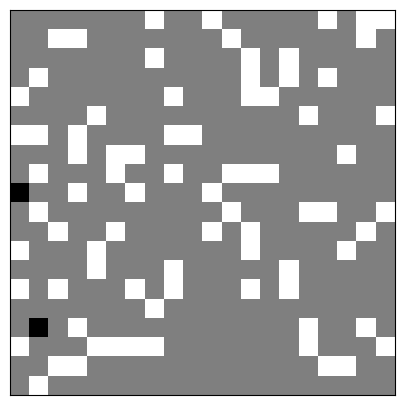

In [306]:
fig, axs = plt.subplots(figsize=(5,5))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(fig, animate, frames = MAX_ITERATIONS)

In [307]:
anim